In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline
# %matplotlib tk

Create a distribution of points in an elliptical annulus

(-1.0, 6.0)

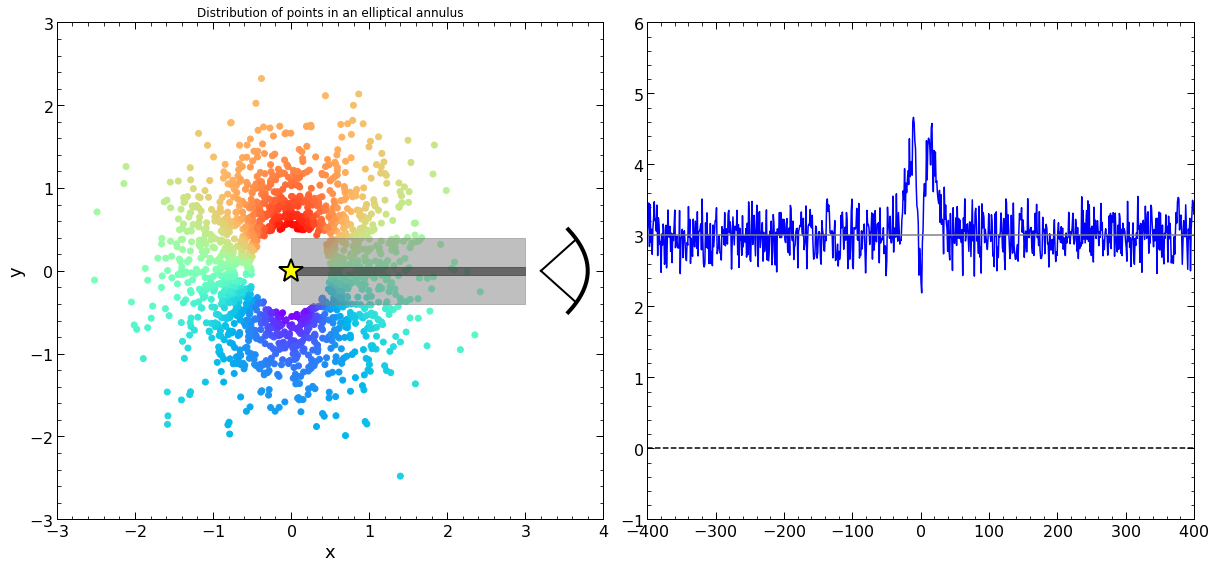

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Define the parameters of the circular annulus
r1, r2 = 0.51, 6 # inner and outer radii of the annulus


# Generate random points within the annulus
n_points = 2000
theta = 2*np.pi*np.random.rand(n_points)
# r = np.sqrt(np.random.uniform(r1**2, r2**2, n_points))
r = np.sqrt(np.random.exponential(1, n_points))
x = r*np.cos(theta)
y = r*np.sin(theta)


# mask points outside the annulus:
x[r<r1] = 0
y[r<r1] = 0
x[r>r2] = 0
y[r>r2] = 0

r = r[x!=0]
theta = theta[x!=0]
x = x[x!=0]
y = y[y!=0]


# Define angular velocity of objects
omega = np.sqrt(1/r**3)


# Compute the color of each point based on its position in the ellipse
v = omega*r
vx = v*np.sin(theta)
color = vx


# Compute spectrum of each blob
# Parameters for each cloud:
def gaussian(amp, lw, offset, cont, x):
    return amp * np.exp(-0.5*(x-offset)**2 / lw**2) + cont


# Give each cloud a random velocity along the line of sight
los_vel = np.random.uniform(-50, 50, size=len(omega))


# Give each cloud an opacity:
opacity = np.random.uniform(0.5, 1, size=len(omega))


# Generate emission spectrum for one cloud:
velRange = np.linspace(-400, 400, int(800/1))
em_spec = gaussian(2, 15, 0, 3, velRange)
em_noise = np.random.uniform(-0.3, 0.3, size=len(velRange))
em_spec = em_spec + em_noise


# Generate absorption spectrum for one cloud:
abs_noise = np.random.uniform(-0.3, 0.3, size=len(velRange))
abs_spec = -(gaussian(3*opacity[1], 5, 0, 0, velRange) + abs_noise)
spec = em_spec + abs_spec 



# Create a scatter plot of the points with colors
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17, 8))
ax1.scatter(x, y, c=color, cmap='rainbow')
ax1.fill_between(x=[0, 3], y1=[0.05, 0.05], y2=[-0.05, -0.05], color='k', alpha=0.7)
ax1.fill_between(x=[0, 3], y1=[0.4, 0.4], y2=[-0.4, -0.4], color='grey', alpha=0.5)
yp = np.linspace(-0.5, 0.5, 20)
xp = -yp**2 + 3.8
ax1.plot(xp, yp, ls='-', c='k', lw=4)
ax1.plot([3.65, 3.2], [0.38, 0], ls='-', lw=2, c='k')
ax1.plot([3.65, 3.2], [-0.38, 0], ls='-', lw=2, c='k')


# Add labels and title
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim(-3, 4)
ax1.set_ylim(-3, 3)
ax1.set_title('Distribution of points in an elliptical annulus')

# Add a central point source
ax1.plot(0, 0, '*', ms=25, color='yellow', mec='k', mew=2)

# Add a spectrum plot
ax2.plot(velRange, spec, ls='-', c='b')
ax2.axhline(y=3, c='grey', ls='-')
ax2.axhline(y=0, c='k', ls='--')
ax2.set_xlim(-400, 400)
ax2.set_ylim(-1, 6)

In [14]:
import matplotlib.animation as animation

N = len(x)   # number of objects in the disk

# Define time step and duration of simulation
dt = 0.001   # in years
t_max = 0.5   # in years

# Define arrays to store positions of objects
x_arr = np.zeros((N, int(t_max/dt)))
y_arr = np.zeros((N, int(t_max/dt)))

velRange = np.linspace(-400, 400, int(800/1))

# Generate random velocity along the line of sight for each cloud
los_vel_em = np.random.uniform(-70, 70, size=len(omega))
los_vel_abs = np.random.uniform(-20, 20, size=len(omega))

# Generate random linewidths for each cloud
lw_em = np.random.uniform(50, 100, size=len(omega))
lw_abs = np.random.uniform(2, 5, size=len(omega))


# Give each cloud an opacity:
opacity = np.random.uniform(0.8, 1, size=len(omega))

# Generate random line strengths in emission:
amp = np.random.uniform(0.5, 1, size=len(omega))


for i in range(int(t_max/dt)):

    x = r * np.cos(theta + omega*i*dt)
    y = r * np.sin(theta + omega*i*dt)

    # Store positions and velocities in arrays
    x_arr[:,i] = x
    y_arr[:,i] = y
    
    # redefine color for proper red/blueshift
    v = omega*r
    vx = v*np.sin(theta + omega*i*dt)
    color = vx
    
    # Now calculate the spectrum for each cloud and add them all
    pt_within_beam = np.where((y>-0.4)&(y<0.4))[0]
    pt_absorbing = np.where((y>-0.01)&(y<0.01)&(x>0.0))[0]
    

    tot_em_spec = np.zeros((len(pt_within_beam), len(velRange)))
    tot_abs_spec = np.zeros((len(pt_absorbing), len(velRange)))
    
    for ind, cldId in enumerate(pt_within_beam):
        # Generate emission spectrum for one cloud:
        em_spec = gaussian(amp[cldId], lw_em[cldId], los_vel_em[cldId], 3, velRange)
        em_noise = np.random.uniform(-0.7, 0.7, size=len(velRange))
        tot_em_spec[ind] = em_spec + em_noise
    
    for ind, cldId in enumerate(pt_absorbing):
        # Generate emission spectrum for one cloud:
        abs_noise = np.random.uniform(-0.7, 0.7, size=len(velRange))
        abs_spec = (gaussian((amp[cldId]+3)*opacity[cldId], lw_abs[cldId],
                              los_vel_abs[cldId], 0, velRange) - abs_noise)
        tot_abs_spec[ind] = abs_spec


    # Generate integrated spectrum for the line of sight:
    
    spec = np.mean(tot_em_spec, axis=0) - np.mean(tot_abs_spec, axis=0) 
  
    # Plot the spectrum

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17, 8))
    ax1.scatter(x, y, c=color, cmap='rainbow')
    ax1.plot(0, 0, '*', ms=25, color='yellow', mec='k', mew=2)
    ax1.fill_between(x=[0, 2.5], y1=[0.05, 0.05], y2=[-0.05, -0.05], color='k', alpha=0.7)
    ax1.fill_between(x=[0, 2.5], y1=[0.4, 0.4], y2=[-0.4, -0.4], color='grey', alpha=0.5)
    yp = np.linspace(-0.5, 0.5, 20)
    xp = -yp**2 + 3.8
    ax1.plot(xp, yp, ls='-', c='k', lw=4)
    ax1.plot([3.65, 3.2], [0.38, 0], ls='-', lw=2, c='k')
    ax1.plot([3.65, 3.2], [-0.38, 0], ls='-', lw=2, c='k')
    ax1.set_xlim(-3,4)
    ax1.set_ylim(-3,3)
    
    # Add a spectrum plot
    ax2.plot(velRange, spec, ls='-', c='b')
    ax2.axhline(y=3, c='grey', ls='-')
    ax2.axhline(y=0, c='k', ls='--')
    ax2.set_xlim(-400, 400)
    ax2.set_ylim(-1, 6)

    plt.savefig('./figs/frame%s.png'%str(i))
    plt.clf()
    plt.close()

In [15]:
# combine all images to make a video

import subprocess

subprocess.run('ffmpeg -i ./figs/frame%d.png -c:v libx264 -r 30 -pix_fmt yuv420p ./figs/out.mp4', shell=True)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

CompletedProcess(args='ffmpeg -i ./figs/frame%d.png -c:v libx264 -r 30 -pix_fmt yuv420p ./figs/out.mp4', returncode=0)